In [1]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split

from LSPIN_model import Model
from utils import convertToOneHot, DataSet

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

### Data Generation (Exp 4)

In [4]:
np.random.seed(34)
X1 = np.random.normal(loc=1,scale=0.5,size=(500,4))
X2 = np.random.normal(loc=-1,scale=0.5,size=(500,4))
logit1 = np.exp(X1[:, 0] *X1[:, 1]  - 0.9)
logit2 = np.exp(np.sum(X2[:, 2:4]**2, axis = 1) - 2.5)
Y1 = 1.*(1/(1+logit1) > 0.5).reshape(-1,1)
Y2 = 1.*(1/(1+logit2) > 0.5).reshape(-1,1)

In [7]:
#### add noise to the next 46 irrelevant features
X = np.concatenate((X1,X2),axis=0)
noise = np.random.normal(loc=0,scale=0.5,size=(1000,46))
X = np.concatenate((X,noise),axis=1)
Y = np.concatenate((Y1,Y2),axis=0).reshape(-1)

In [8]:
ground_truth = np.zeros((1000,50))
ground_truth[:500,:2] = 1
ground_truth[500:,2:4] = 1

In [9]:
Y_onehot = convertToOneHot(Y.astype(int))

In [10]:
y_g = np.concatenate((Y_onehot,ground_truth),axis=1)

In [11]:
X_non_zeros=np.sum(X,axis=0)!=0
XN=scipy.stats.zscore(X[:,X_non_zeros], axis=0)

In [12]:
x_train,x_test,y_g_train,y_g_test = train_test_split(XN,y_g,train_size=0.95,random_state=34)
x_train,x_valid,y_g_train,y_g_valid = train_test_split(x_train,y_g_train,test_size=0.1,random_state=34)

In [13]:
y_train = y_g_train[:,:2]
y_valid = y_g_valid[:,:2]
y_test = y_g_test[:,:2]

In [15]:
g_train = y_g_train[:,2:]
g_valid = y_g_valid[:,2:]
g_test = y_g_test[:,2:]

In [17]:
dataset = DataSet(**{'_data':x_train, '_labels':y_train,
                '_valid_data':x_valid, '_valid_labels':y_valid,
                '_test_data':x_test, '_test_labels':y_test})

### LSPIN

In [16]:
def lspin_objective(trial):  
    
    global model
            
    params = {
        "feature_selection" : True,
        "sigma" : 0.5,
        "display_step" : 200,
        "hidden_layers_node" : [200,200,2], # 2 hidden layers with 200 nodes each, output layer with 2 nodes
        "input_node" : x_train.shape[1],
        "output_node" : 2
    }
    params['stddev_input'] = 0.1
    params['activation']= 'tanh' 
    params['batch_size']= x_train.shape[0] 
    params['feature_selection_dimension']=[100,100] 
    
    params['lam'] = trial.suggest_loguniform('lam',1.33,1.35) 
    params['learning_rate'] = trial.suggest_loguniform('learning_rate',0.03,0.05) 
    num_epoch = trial.suggest_categorical('num_epoch', [1000,1200])

    model_dir = None
    model = Model(**params)
    train_acces, train_losses, val_acces, val_losses = model.train(trial, dataset, model_dir, num_epoch=num_epoch)
        
    print("In trial:---------------------")    
    loss=(1-val_acces[-1])
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [19]:
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(lspin_objective, n_trials=20, callbacks=[callback])

[I 2021-06-01 01:00:48,486] A new study created in memory with name: no-name-911fcc18-0cfe-4253-a9c6-04bbf29f2181








Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



num_samples : 855
Epoch: 200 train loss=1.254112244 valid loss= 1.619361162 valid acc= 0.621052623
train reg_fs: 0.9116310477256775
Epoch: 400 train loss=0.873710275 valid loss= 0.909499824 valid acc= 0.852631569
train reg_fs: 0.5610585808753967
Epoch: 600 train loss=0.631013632 valid loss= 0.546499968 valid acc= 0.936842084
train reg_fs: 0.3194192051887512
Epoch: 800 train loss=0.598553777 valid loss= 

[I 2021-06-01 01:00:57,050] Trial 0 finished with value: 0.042105257511138916 and parameters: {'lam': 1.3441896955262673, 'learning_rate': 0.043901854958916894, 'num_epoch': 1000}. Best is trial 0 with value: 0.042105257511138916.


Epoch: 1000 train loss=0.561101615 valid loss= 0.482956469 valid acc= 0.957894742
train reg_fs: 0.27298909425735474
Optimization Finished!
test loss: 0.48407602310180664, test acc: 0.9399999976158142
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.307415485 valid loss= 1.631120086 valid acc= 0.621052623
train reg_fs: 0.9546396732330322
Epoch: 400 train loss=1.081118941 valid loss= 1.126800299 valid acc= 0.852631569
train reg_fs: 0.7788937091827393
Epoch: 600 train loss=0.769215226 valid loss= 0.732049108 valid acc= 0.926315784
train reg_fs: 0.4993285834789276
Epoch: 800 train loss=0.647310853 valid loss= 0.541166782 valid acc= 0.947368443
train reg_fs: 0.33497464656829834
Epoch: 1000 train loss=0.608139277 valid loss= 0.496553719 valid acc= 0.947368443
train reg_fs: 0.29403218626976013


[I 2021-06-01 01:01:05,587] Trial 1 finished with value: 0.06315791606903076 and parameters: {'lam': 1.3385102307049286, 'learning_rate': 0.03397470756093665, 'num_epoch': 1200}. Best is trial 0 with value: 0.042105257511138916.


Epoch: 1200 train loss=0.574633598 valid loss= 0.507241607 valid acc= 0.936842084
train reg_fs: 0.2805849313735962
Optimization Finished!
test loss: 0.4934200644493103, test acc: 0.9599999785423279
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.385288477 valid loss= 1.592894316 valid acc= 0.663157880
train reg_fs: 0.9563925862312317
Epoch: 400 train loss=1.087863207 valid loss= 1.199334979 valid acc= 0.800000012
train reg_fs: 0.7847471833229065
Epoch: 600 train loss=0.823230028 valid loss= 0.764731169 valid acc= 0.905263186
train reg_fs: 0.518298327922821
Epoch: 800 train loss=0.689340830 valid loss= 0.580786228 valid acc= 0.947368443
train reg_fs: 0.3503880798816681
Epoch: 1000 train loss=0.635396123 valid loss= 0.518185556 valid acc= 0.957894742
train reg_fs: 0.2982105314731598


[I 2021-06-01 01:01:14,083] Trial 2 finished with value: 0.05263155698776245 and parameters: {'lam': 1.3300823916980833, 'learning_rate': 0.03182794729110173, 'num_epoch': 1200}. Best is trial 0 with value: 0.042105257511138916.


Epoch: 1200 train loss=0.567062974 valid loss= 0.524536133 valid acc= 0.947368443
train reg_fs: 0.27722057700157166
Optimization Finished!
test loss: 0.5380192995071411, test acc: 0.9399999976158142
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.394518495 valid loss= 1.580102682 valid acc= 0.621052623
train reg_fs: 0.9796023368835449
Epoch: 400 train loss=1.111853242 valid loss= 1.231227398 valid acc= 0.789473712
train reg_fs: 0.8230224847793579
Epoch: 600 train loss=0.867260337 valid loss= 0.862061739 valid acc= 0.894736826
train reg_fs: 0.5665410161018372
Epoch: 800 train loss=0.681341887 valid loss= 0.588927567 valid acc= 0.926315784
train reg_fs: 0.3581277132034302
Epoch: 1000 train loss=0.611821771 valid loss= 0.511274874 valid acc= 0.936842084
train reg_fs: 0.2988295555114746


[I 2021-06-01 01:01:22,489] Trial 3 finished with value: 0.0736842155456543 and parameters: {'lam': 1.349043062889026, 'learning_rate': 0.031222603098346905, 'num_epoch': 1200}. Best is trial 0 with value: 0.042105257511138916.


Epoch: 1200 train loss=0.618151188 valid loss= 0.514380872 valid acc= 0.926315784
train reg_fs: 0.2813444137573242
Optimization Finished!
test loss: 0.5322886109352112, test acc: 0.9200000166893005
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.262318730 valid loss= 1.560855865 valid acc= 0.663157880
train reg_fs: 0.9202236533164978
Epoch: 400 train loss=0.943211377 valid loss= 0.903634965 valid acc= 0.905263186
train reg_fs: 0.6270485520362854
Epoch: 600 train loss=0.673957884 valid loss= 0.549897432 valid acc= 0.968421042
train reg_fs: 0.3490069508552551
Epoch: 800 train loss=0.584874034 valid loss= 0.480701089 valid acc= 0.968421042
train reg_fs: 0.28986304998397827


[I 2021-06-01 01:01:29,723] Trial 4 finished with value: 0.03157895803451538 and parameters: {'lam': 1.3427889365967025, 'learning_rate': 0.04073013242556997, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.593711913 valid loss= 0.468188137 valid acc= 0.968421042
train reg_fs: 0.27579039335250854
Optimization Finished!
test loss: 0.46843674778938293, test acc: 0.9800000190734863
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.199468613 valid loss= 1.534624577 valid acc= 0.631578922
train reg_fs: 0.8825714588165283
Epoch: 400 train loss=0.826973021 valid loss= 0.769425273 valid acc= 0.915789485
train reg_fs: 0.49549034237861633
Epoch: 600 train loss=0.626063466 valid loss= 0.509782016 valid acc= 0.968421042
train reg_fs: 0.3044997453689575
Epoch: 800 train loss=0.584039271 valid loss= 0.517597079 valid acc= 0.947368443
train reg_fs: 0.2789304852485657


[I 2021-06-01 01:01:37,085] Trial 5 finished with value: 0.0736842155456543 and parameters: {'lam': 1.3450180559372549, 'learning_rate': 0.04879068607175385, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.581156313 valid loss= 0.515788257 valid acc= 0.926315784
train reg_fs: 0.2708032429218292
Optimization Finished!
test loss: 0.44814762473106384, test acc: 0.9800000190734863
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.283905745 valid loss= 1.573699594 valid acc= 0.589473665
train reg_fs: 0.9249128699302673
Epoch: 400 train loss=0.995333076 valid loss= 1.014389038 valid acc= 0.873684227
train reg_fs: 0.6904668211936951
Epoch: 600 train loss=0.733595490 valid loss= 0.621836245 valid acc= 0.957894742
train reg_fs: 0.4113979935646057
Epoch: 800 train loss=0.639108062 valid loss= 0.501679540 valid acc= 0.978947341
train reg_fs: 0.31266579031944275
Epoch: 1000 train loss=0.591555119 valid loss= 0.478138566 valid acc= 0.968421042
train reg_fs: 0.28704187273979187


[I 2021-06-01 01:01:45,732] Trial 6 finished with value: 0.042105257511138916 and parameters: {'lam': 1.3311733977231612, 'learning_rate': 0.039775659117224804, 'num_epoch': 1200}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1200 train loss=0.607420444 valid loss= 0.472596228 valid acc= 0.957894742
train reg_fs: 0.2734355330467224
Optimization Finished!
test loss: 0.5290484428405762, test acc: 0.9200000166893005
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.421991467 valid loss= 1.603948355 valid acc= 0.600000024
train reg_fs: 0.966999351978302
Epoch: 400 train loss=1.099927664 valid loss= 1.254536629 valid acc= 0.757894754
train reg_fs: 0.7876020669937134
Epoch: 600 train loss=0.809497476 valid loss= 0.758542180 valid acc= 0.884210527
train reg_fs: 0.5001546740531921
Epoch: 800 train loss=0.654568195 valid loss= 0.545771956 valid acc= 0.936842084
train reg_fs: 0.33670610189437866
Epoch: 1000 train loss=0.637575567 valid loss= 0.491696268 valid acc= 0.947368443
train reg_fs: 0.29489511251449585


[I 2021-06-01 01:01:54,215] Trial 7 finished with value: 0.05263155698776245 and parameters: {'lam': 1.341766072043896, 'learning_rate': 0.031559033777208444, 'num_epoch': 1200}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1200 train loss=0.606730223 valid loss= 0.478935719 valid acc= 0.947368443
train reg_fs: 0.2809135317802429
Optimization Finished!
test loss: 0.49361228942871094, test acc: 0.9399999976158142
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.284812927 valid loss= 1.560256481 valid acc= 0.621052623
train reg_fs: 0.9317033290863037
Epoch: 400 train loss=0.996865392 valid loss= 0.988492131 valid acc= 0.905263186
train reg_fs: 0.705984354019165
Epoch: 600 train loss=0.730993867 valid loss= 0.622072756 valid acc= 0.947368443
train reg_fs: 0.4089203178882599
Epoch: 800 train loss=0.640137255 valid loss= 0.525002837 valid acc= 0.957894742
train reg_fs: 0.3040807843208313
Epoch: 1000 train loss=0.588551641 valid loss= 0.507530749 valid acc= 0.947368443
train reg_fs: 0.2811480760574341


[I 2021-06-01 01:02:02,638] Trial 8 finished with value: 0.0736842155456543 and parameters: {'lam': 1.3318946299427659, 'learning_rate': 0.03781420069226251, 'num_epoch': 1200}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1200 train loss=0.569911718 valid loss= 0.512230635 valid acc= 0.926315784
train reg_fs: 0.2721129357814789
Optimization Finished!
test loss: 0.48447471857070923, test acc: 0.9399999976158142
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.408545494 valid loss= 1.660851955 valid acc= 0.589473665
train reg_fs: 0.9894586801528931
Epoch: 400 train loss=1.159676075 valid loss= 1.262583137 valid acc= 0.821052611
train reg_fs: 0.8468783497810364
Epoch: 600 train loss=0.914080024 valid loss= 0.893278539 valid acc= 0.905263186
train reg_fs: 0.6154711246490479
Epoch: 800 train loss=0.696946859 valid loss= 0.622202277 valid acc= 0.936842084
train reg_fs: 0.3896246552467346
Epoch: 1000 train loss=0.632662296 valid loss= 0.530737519 valid acc= 0.936842084
train reg_fs: 0.31162646412849426


[I 2021-06-01 01:02:11,155] Trial 9 finished with value: 0.05263155698776245 and parameters: {'lam': 1.3494033736747533, 'learning_rate': 0.030055744070486678, 'num_epoch': 1200}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1200 train loss=0.615491390 valid loss= 0.508177102 valid acc= 0.947368443
train reg_fs: 0.2884170711040497
Optimization Finished!
test loss: 0.4961863160133362, test acc: 0.9599999785423279
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.201194525 valid loss= 1.555450320 valid acc= 0.610526323
train reg_fs: 0.8745065331459045
Epoch: 400 train loss=0.780279994 valid loss= 0.740013838 valid acc= 0.894736826
train reg_fs: 0.45245492458343506
Epoch: 600 train loss=0.622243881 valid loss= 0.519316792 valid acc= 0.936842084
train reg_fs: 0.29901373386383057
Epoch: 800 train loss=0.591980100 valid loss= 0.516217232 valid acc= 0.936842084
train reg_fs: 0.2770141661167145


[I 2021-06-01 01:02:18,569] Trial 10 finished with value: 0.0736842155456543 and parameters: {'lam': 1.337473258605201, 'learning_rate': 0.04914927550954319, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.550195932 valid loss= 0.513797820 valid acc= 0.926315784
train reg_fs: 0.26951175928115845
Optimization Finished!
test loss: 0.5219305753707886, test acc: 0.8999999761581421
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.283724904 valid loss= 1.636727333 valid acc= 0.589473665
train reg_fs: 0.92737877368927
Epoch: 400 train loss=0.941879749 valid loss= 0.961379528 valid acc= 0.873684227
train reg_fs: 0.6375672817230225
Epoch: 600 train loss=0.659376860 valid loss= 0.551972151 valid acc= 0.947368443
train reg_fs: 0.34404435753822327
Epoch: 800 train loss=0.598914564 valid loss= 0.483910739 valid acc= 0.957894742
train reg_fs: 0.2912719249725342


[I 2021-06-01 01:02:26,181] Trial 11 finished with value: 0.042105257511138916 and parameters: {'lam': 1.3450803626693715, 'learning_rate': 0.04143043397095458, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.589561999 valid loss= 0.472359985 valid acc= 0.957894742
train reg_fs: 0.27783992886543274
Optimization Finished!
test loss: 0.48052501678466797, test acc: 0.9599999785423279
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.223781586 valid loss= 1.501100421 valid acc= 0.684210539
train reg_fs: 0.9073265194892883
Epoch: 400 train loss=0.919708431 valid loss= 0.893490732 valid acc= 0.926315784
train reg_fs: 0.6223929524421692
Epoch: 600 train loss=0.703688383 valid loss= 0.604336381 valid acc= 0.947368443
train reg_fs: 0.3794991075992584
Epoch: 800 train loss=0.607617497 valid loss= 0.497309476 valid acc= 0.947368443
train reg_fs: 0.29424911737442017


[I 2021-06-01 01:02:33,500] Trial 12 finished with value: 0.05263155698776245 and parameters: {'lam': 1.3425272126084882, 'learning_rate': 0.04406610951405165, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.573844671 valid loss= 0.488855839 valid acc= 0.947368443
train reg_fs: 0.27501386404037476
Optimization Finished!
test loss: 0.4705983102321625, test acc: 0.9599999785423279
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.240751147 valid loss= 1.597802043 valid acc= 0.589473665
train reg_fs: 0.9062842726707458
Epoch: 400 train loss=0.866972446 valid loss= 0.875794947 valid acc= 0.884210527
train reg_fs: 0.5551687479019165
Epoch: 600 train loss=0.660323501 valid loss= 0.522980571 valid acc= 0.978947341
train reg_fs: 0.32383993268013
Epoch: 800 train loss=0.603530288 valid loss= 0.470864683 valid acc= 0.978947341
train reg_fs: 0.2844407260417938


[I 2021-06-01 01:02:40,752] Trial 13 finished with value: 0.05263155698776245 and parameters: {'lam': 1.3466663049579564, 'learning_rate': 0.04394283619345447, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.586862445 valid loss= 0.483882576 valid acc= 0.947368443
train reg_fs: 0.27403345704078674
Optimization Finished!
test loss: 0.47395581007003784, test acc: 0.9399999976158142
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.281786084 valid loss= 1.598735809 valid acc= 0.600000024
train reg_fs: 0.9362766146659851
Epoch: 400 train loss=1.048246503 valid loss= 1.016316772 valid acc= 0.905263186
train reg_fs: 0.7257301211357117
Epoch: 600 train loss=0.744181395 valid loss= 0.664265752 valid acc= 0.926315784
train reg_fs: 0.41843387484550476
Epoch: 800 train loss=0.644735277 valid loss= 0.536767602 valid acc= 0.936842084
train reg_fs: 0.30719348788261414


[I 2021-06-01 01:02:48,079] Trial 14 finished with value: 0.06315791606903076 and parameters: {'lam': 1.335767309082704, 'learning_rate': 0.03635207970605441, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.595829308 valid loss= 0.517926514 valid acc= 0.936842084
train reg_fs: 0.2823343575000763
Optimization Finished!
test loss: 0.47483402490615845, test acc: 0.9800000190734863
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.243453383 valid loss= 1.588944435 valid acc= 0.600000024
train reg_fs: 0.8924435377120972
Epoch: 400 train loss=0.830796719 valid loss= 0.858634889 valid acc= 0.884210527
train reg_fs: 0.5293391346931458
Epoch: 600 train loss=0.642660379 valid loss= 0.529255807 valid acc= 0.947368443
train reg_fs: 0.3179936707019806
Epoch: 800 train loss=0.593680501 valid loss= 0.499849409 valid acc= 0.957894742
train reg_fs: 0.2825910747051239


[I 2021-06-01 01:02:55,417] Trial 15 finished with value: 0.06315791606903076 and parameters: {'lam': 1.3415826987994706, 'learning_rate': 0.044854023911541585, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.579146743 valid loss= 0.522459030 valid acc= 0.936842084
train reg_fs: 0.2722783088684082
Optimization Finished!
test loss: 0.47034066915512085, test acc: 0.9599999785423279
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.273794532 valid loss= 1.527543306 valid acc= 0.684210539
train reg_fs: 0.9361634254455566
Epoch: 400 train loss=0.980986118 valid loss= 0.982727885 valid acc= 0.915789485
train reg_fs: 0.7015817165374756
Epoch: 600 train loss=0.710921526 valid loss= 0.606474042 valid acc= 0.947368443
train reg_fs: 0.39020615816116333
Epoch: 800 train loss=0.618854165 valid loss= 0.514963388 valid acc= 0.957894742
train reg_fs: 0.29943370819091797


[I 2021-06-01 01:03:02,915] Trial 16 finished with value: 0.06315791606903076 and parameters: {'lam': 1.3442704303639121, 'learning_rate': 0.04158840200421256, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.562092423 valid loss= 0.514636278 valid acc= 0.936842084
train reg_fs: 0.2812439799308777
Optimization Finished!
test loss: 0.5461808443069458, test acc: 0.9200000166893005
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.185560703 valid loss= 1.459789991 valid acc= 0.663157880
train reg_fs: 0.8747812509536743
Epoch: 400 train loss=0.851224244 valid loss= 0.772524834 valid acc= 0.926315784
train reg_fs: 0.5220171809196472
Epoch: 600 train loss=0.628189564 valid loss= 0.511338472 valid acc= 0.978947341
train reg_fs: 0.31825166940689087
Epoch: 800 train loss=0.617377222 valid loss= 0.476653725 valid acc= 0.968421042
train reg_fs: 0.28062254190444946


[I 2021-06-01 01:03:10,221] Trial 17 finished with value: 0.05263155698776245 and parameters: {'lam': 1.3397537888211304, 'learning_rate': 0.046512793538948896, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.573587298 valid loss= 0.475879192 valid acc= 0.947368443
train reg_fs: 0.27064844965934753
Optimization Finished!
test loss: 0.5142347812652588, test acc: 0.9399999976158142
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.315408587 valid loss= 1.706719518 valid acc= 0.557894766
train reg_fs: 0.9579218626022339
Epoch: 400 train loss=1.046548843 valid loss= 1.120247245 valid acc= 0.852631569
train reg_fs: 0.7580086588859558
Epoch: 600 train loss=0.770949841 valid loss= 0.678738773 valid acc= 0.926315784
train reg_fs: 0.4531468152999878
Epoch: 800 train loss=0.631241024 valid loss= 0.524845302 valid acc= 0.957894742
train reg_fs: 0.3300839960575104


[I 2021-06-01 01:03:17,437] Trial 18 finished with value: 0.03157895803451538 and parameters: {'lam': 1.347036247772005, 'learning_rate': 0.03661359121365558, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.590340018 valid loss= 0.490540266 valid acc= 0.968421042
train reg_fs: 0.29161539673805237
Optimization Finished!
test loss: 0.491066038608551, test acc: 0.9800000190734863
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.323880434 valid loss= 1.588939428 valid acc= 0.663157880
train reg_fs: 0.9586673378944397
Epoch: 400 train loss=1.061658263 valid loss= 1.105228066 valid acc= 0.873684227
train reg_fs: 0.7861180305480957
Epoch: 600 train loss=0.846952677 valid loss= 0.766676307 valid acc= 0.947368443
train reg_fs: 0.53788822889328
Epoch: 800 train loss=0.664511323 valid loss= 0.572855711 valid acc= 0.947368443
train reg_fs: 0.36250200867652893


[I 2021-06-01 01:03:24,762] Trial 19 finished with value: 0.05263155698776245 and parameters: {'lam': 1.347727912799834, 'learning_rate': 0.035197258354028226, 'num_epoch': 1000}. Best is trial 4 with value: 0.03157895803451538.


Epoch: 1000 train loss=0.623191416 valid loss= 0.501978040 valid acc= 0.947368443
train reg_fs: 0.2994476556777954
Optimization Finished!
test loss: 0.5087347626686096, test acc: 0.9599999785423279
In trial:---------------------


In [20]:
gate_mat_nonl=best_model.get_prob_alpha(x_train)

In [25]:
best_lr = study.best_params['learning_rate']
best_epoch = study.best_params['num_epoch']
best_lam = study.best_params['lam']

test_acc, loss = best_model.evaluate(x_test,y_test)
            
print("Trial Finished*************")
print("Best model's lambda: {}".format(best_lam))
print("Best model's learning rate: {}".format(best_lr))
print("Best model's num of epochs: {}".format(best_epoch))
print("Test acc : {}".format(test_acc))

test loss: 0.46843674778938293, test acc: 0.9800000190734863
Saving model..
Trial Finished*************
Best model's lambda: 1.3427889365967025
Best model's learning rate: 0.04073013242556997
Best model's num of epochs: 1000
Test acc : 0.9800000190734863


### Comparing the training gates

In [43]:
from matplotlib import cm,colors
import matplotlib

cmap = cm.Blues 
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xlabel_size = 35
ylabel_size = 35
xtick_size = 20
ytick_size = 20
bar_label_size = 20

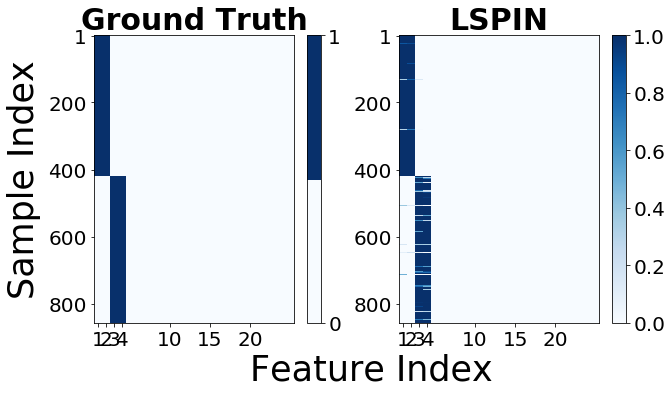

In [44]:
fig, axes = plt.subplots(1, 2, sharex=True,sharey=False,figsize=(10,6))

fig.add_subplot(111, frameon=False)
matplotlib.rc('xtick', labelsize=xtick_size) 

g_train_label = 1*(g_train[:,2] == 1)
sorted_order_train = np.concatenate((np.where(g_train_label == 0)[0],np.where(g_train_label == 1)[0]))

im1 = axes[0].imshow(g_train[sorted_order_train,:25],aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold")
axes[0].set_xticks([0,1,2,3,9,14,19])
axes[0].set_xticklabels([1,2,3,4,10,15,20],fontsize=xtick_size)
axes[0].set_yticks([0,199,399,599,799])
axes[0].set_yticklabels([1,200,400,600,800],fontsize=ytick_size)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size,labelpad=7)

im3 = axes[1].imshow(gate_mat_nonl[sorted_order_train,:25],aspect='auto',cmap=cmap)
axes[1].set_title("LSPIN",fontsize=title_size,fontweight="bold")
axes[1].set_yticks([0,199,399,599,799])
axes[1].set_yticklabels([1,200,400,600,800],fontsize=ytick_size)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=bar_label_size)
cbar = fig.colorbar(im3,ax=axes[1])
cbar.ax.tick_params(labelsize=bar_label_size)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Feature Index",fontsize=xlabel_size)

plt.tight_layout()

In [36]:
### TPR of the discoveries
print("True Positive Rate: {:.4f}".format(np.sum((g_train > 0) & (gate_mat_nonl >0))/np.sum(g_train > 0)))

True Positive Rate: 0.9912


In [37]:
### FDR of the discoveries
print("False Discovery Rate: {:.4f}".format(np.sum((g_train ==0)&(gate_mat_nonl >0))/np.sum(gate_mat_nonl >0)))

False Discovery Rate: 0.0202


### Compare the test gates

In [38]:
gate_mat_nonl_test = best_model.get_prob_alpha(x_test)

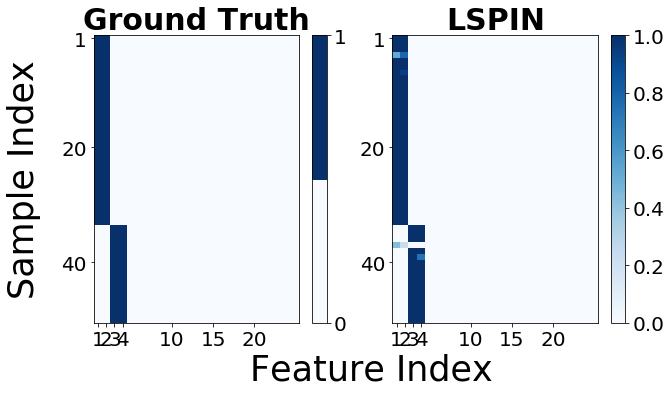

In [54]:
fig, axes = plt.subplots(1, 2, sharex=True,sharey=False,figsize=(10,6))

fig.add_subplot(111, frameon=False)

matplotlib.rc('xtick', labelsize=xtick_size) 

g_test_label = 1*(g_test[:,2] == 1)
sorted_order_test = np.concatenate((np.where(g_test_label == 0)[0],np.where(g_test_label == 1)[0]))

im1 = axes[0].imshow(g_test[sorted_order_test,:25],aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold")
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size,labelpad=20)
axes[0].set_xticks([0,1,2,3,9,14,19])
axes[0].set_xticklabels([1,2,3,4,10,15,20],fontsize=xtick_size)
axes[0].set_yticks([0,19,39])
axes[0].set_yticklabels([1,20,40],fontsize=ytick_size)

im2 = axes[1].imshow(gate_mat_nonl_test[sorted_order_test,:25],aspect='auto',cmap=cmap)
axes[1].set_title("LSPIN",fontsize=title_size,fontweight="bold")
axes[1].set_yticks([0,19,39])
axes[1].set_yticklabels([1,20,40],fontsize=ytick_size)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=bar_label_size)
cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=bar_label_size)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Feature Index",fontsize=xlabel_size)
plt.tight_layout()

In [49]:
### TPR
print("True Positive Rate: {:.4f}".format(np.sum((g_test > 0) & (gate_mat_nonl_test >0))/np.sum(g_test > 0)))

True Positive Rate: 0.9800


In [50]:
### FDR:
print("False Discovery Rate: {:.4f}".format(np.sum((g_test ==0)&(gate_mat_nonl_test >0))/np.sum(gate_mat_nonl_test >0)))

False Discovery Rate: 0.0200
